In [188]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle

%matplotlib inline

In [189]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer

from gensim.models import word2vec
from gensim.models import KeyedVectors
from glove import Corpus, Glove

In [190]:
def generate_word2vec_text8(saveTo = 'models/text8.model'):
    sentences = word2vec.Text8Corpus('data/text8')
    model = word2vec.Word2Vec(sentences, size=EMBEDDING_DIM)
    model.save(saveTo)
    model.wv.save_word2vec_format(saveTo + '.bin', binary=True)
    print('DONE! Saved to', saveTo)

def generate_glove_text8(saveTo = 'models/glovetext8.model'):
    import itertools
    sentences = list(itertools.islice(word2vec.Text8Corpus('data/text8'),None))
    corpus = Corpus()
    corpus.fit(sentences, window=10)
    glove = Glove(no_components=EMBEDDING_DIM,learning_rate=0.05)
    glove.fit(corpus.matrix, epochs=30,no_threads=4,verbose=True)
    glove.add_dictionary(corpus.dictionary)
    glove.save(saveTo)
    print('DONE! Saved to', saveTo)
    
def load_data(word_count, emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 6]
    # Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
#     data,patterns = remove_empty_patterns(data,patterns)
    return data

def clean_text(text):
    punct_str = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~«»“…‘”\t'
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(".*?\[(.*?)\]","",text) # Take out any [action] text in the transcript
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]

def balance_data(data):
    min_sample = min(data.groupby('emotion').count()['emotion_code'])
    emotions_list = list(data['emotion'].unique())
    samples = []
    for emotion in emotions_list:
        samples.append(data[data.emotion == emotion].sample(n=min_sample))
    result = pd.concat(samples).sample(frac=1)
    return result


In [234]:
emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data = load_data(3, emotional_mapping)
# data = balance_data(data)
df = data[['text','emotion_code']]
df.head()

,text,emotion_code
Ses01F_impro01_F002,is there a problem,3
Ses01F_impro01_F005,well what's the problem let me change it,3
Ses01F_impro01_F006,what i'm getting an id this is why i'm here my...,4
Ses01F_impro01_F007,how am i supposed to get an id without an id h...,4
Ses01F_impro01_F008,i'm here to get an id,4


In [251]:
total = sum(data.groupby('emotion').count()['emotion_code'])
(data.groupby('emotion').count() / total) * 100

,start_time,end_time,text,wav_path,valence,arousal,dominance,emotion_code
emotion,,,,,,,,
ang,15.887412,15.887412,15.887412,15.887412,15.887412,15.887412,15.887412,15.887412
exc,13.760751,13.760751,13.760751,13.760751,13.760751,13.760751,13.760751,13.760751
fru,25.801407,25.801407,25.801407,25.801407,25.801407,25.801407,25.801407,25.801407
hap,7.849883,7.849883,7.849883,7.849883,7.849883,7.849883,7.849883,7.849883
neu,22.095387,22.095387,22.095387,22.095387,22.095387,22.095387,22.095387,22.095387
sad,14.605160,14.605160,14.605160,14.605160,14.605160,14.605160,14.605160,14.605160


In [236]:
data_balanced = balance_data(data)
df_balanced = data_balanced[['text','emotion_code']]
df_balanced.head()
data_balanced.groupby('emotion').count()

,start_time,end_time,text,wav_path,valence,arousal,dominance,emotion_code
emotion,,,,,,,,
ang,502,502,502,502,502,502,502,502
exc,502,502,502,502,502,502,502,502
fru,502,502,502,502,502,502,502,502
hap,502,502,502,502,502,502,502,502
neu,502,502,502,502,502,502,502,502
sad,502,502,502,502,502,502,502,502


## Parameter

In [209]:
# DATASET
TEST_SIZE      = 0.2

# EMBEDDING
MAX_NUM_WORDS  = 2954 # 2500, 2000, 2700
# MAX_NUM_WORDS  = # 1800, 2000, 2201
EMBEDDING_DIM  = 200
MAX_SEQ_LENGTH = 100
USE_GLOVE      = True

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [10,10,10]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 40
RUNS           = 5
VAL_SIZE       = 0.1

## Preprocessing

In [210]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)

In [211]:
def max_length(lines):
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer()#num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

length = max_length(x_train)
word_index = tokenizer.word_index

result = [len(x.split()) for x in x_train]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))

print('vocabulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 100 / min length: 3 / mean length: 13 / limit length: 100
vocabulary size: 2943 / limit: 2954


In [212]:
len(data), len(y_train)

(5116, 5116)

# Embeddings

In [213]:
def create_glove_embeddings(data = None, use_text8 = False, LEARNING_RATE=0.05, EPOCHS=30, NO_THREADS=4):
    model = None
    if(use_text8):
        model = Glove.load('models/glovetext8.model')
    else:
        if(data != None):
            corpus = Corpus()
            corpus.fit(data, window=10)
            model = Glove(no_components=EMBEDDING_DIM,learning_rate=LEARNING_RATE)
            model.fit(corpus.matrix, epochs=EPOCHS,no_threads=NO_THREADS,verbose=True)
            model.add_dictionary(corpus.dictionary)
        else:
            print('No data found. Using text8 Corpus')
            model = Glove.load('models/glovetext8.model')
    
    embeddings_index = {}
    for word,index in model.dictionary.items():
        embeddings_index[word] = model.word_vectors[index]
    
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     weights=[embedding_matrix], trainable=True)
    
def create_word2vec_embeddings(data = None, use_text8 = False):
    model = None
    if(use_text8):
        model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    else:
        if(data != None):  
            model = word2vec.Word2Vec(data, size=EMBEDDING_DIM)
        else:
            print('No data found. Using text8 Corpus')
            model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    
    embeddings_index = {}
    for word in model.wv.index2word:
        embeddings_index[word] = model[word]
        
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length = MAX_SEQ_LENGTH,
                    weights= [embedding_matrix], trainable=True)

# Model Definition

## Training

In [76]:
embedding_data = [x.split() for x in x_train]
emb_layers = [create_word2vec_embeddings(use_text8=True),
              create_word2vec_embeddings(embedding_data),
              create_glove_embeddings(use_text8=True),
              create_glove_embeddings(embedding_data)
             ]

emb_layers_names = ['word2vectext8','word2veciemocap','glovetext8','gloveiemocap']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [77]:
print(len(data),len(y_train))

(5116, 5116)


In [ ]:
import cnn_model

for index,lay in enumerate(emb_layers):
    
    histories = []
    
    for i in range(RUNS):
        print('Running iteration %i/%i' % (i+1, RUNS))

        X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)

        emb_layer = None
        if USE_GLOVE:
            emb_layer = lay#emb_layers[2] #create_word2vec_embeddings(result)

        model = cnn_model.build_cnn(
            embedding_layer=emb_layer,
            num_words=MAX_NUM_WORDS,
            embedding_dim=EMBEDDING_DIM,
            filter_sizes=FILTER_SIZES,
            feature_maps=FEATURE_MAPS,
            max_seq_length=MAX_SEQ_LENGTH,
            dropout_rate=DROPOUT_RATE
        )

        model.compile(
            loss='binary_crossentropy',
            optimizer=Adadelta(clipvalue=3),
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, labels,
            epochs=NB_EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                       verbose=1, save_best_only=True, mode='min'),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                      ]
        )
        histories.append(history.history)
        
    with open('history/unbalanced_'+emb_layers_names[index]+'_'+str(MAX_NUM_WORDS)+'.pkl', 'wb') as f:
        pickle.dump(histories, f)

In [80]:
MAX_NUM_WORDS_AR = [2000, 2201,1800]
for num in MAX_NUM_WORDS_AR:
    MAX_NUM_WORDS = num
    emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
    data = load_data(3, emotional_mapping)
    data = balance_data(data)
    df = data[['text','emotion_code']]
    df.head()
    x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(x_train)
    sequences = tokenizer.texts_to_sequences(x_train)

    length = max_length(x_train)
    word_index = tokenizer.word_index

    result = [len(x.split()) for x in x_train]
    print('Text informations:')
    print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                    np.min(result),
                                                                                    np.mean(result),
                                                                                    MAX_SEQ_LENGTH))

    print('vocabulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

    # Padding all sequences to same length of `MAX_SEQ_LENGTH`
    data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

    embedding_data = [x.split() for x in x_train]
    emb_layers = [create_word2vec_embeddings(use_text8=True),
                  create_word2vec_embeddings(embedding_data),
                  create_glove_embeddings(use_text8=True),
                  create_glove_embeddings(embedding_data)
                 ]
    
    ######################################################
    for index,lay in enumerate(emb_layers):
    
        histories = []

        for i in range(RUNS):
            print('Running iteration %i/%i' % (i+1, RUNS))

            X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)

            emb_layer = None
            if USE_GLOVE:
                emb_layer = lay#emb_layers[2] #create_word2vec_embeddings(result)

            model = cnn_model.build_cnn(
                embedding_layer=emb_layer,
                num_words=MAX_NUM_WORDS,
                embedding_dim=EMBEDDING_DIM,
                filter_sizes=FILTER_SIZES,
                feature_maps=FEATURE_MAPS,
                max_seq_length=MAX_SEQ_LENGTH,
                dropout_rate=DROPOUT_RATE
            )

            model.compile(
                loss='binary_crossentropy',
                optimizer=Adadelta(clipvalue=3),
                metrics=['accuracy']
            )

            history = model.fit(
                X_train, labels,
                epochs=NB_EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                           verbose=1, save_best_only=True, mode='min'),
                           ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                          ]
            )
            histories.append(history.history)

        with open('history/balanced_'+emb_layers_names[index]+'_'+str(MAX_NUM_WORDS)+'.pkl', 'wb') as f:
            pickle.dump(histories, f)
    



Text informations:
max length: 91 / min length: 3 / mean length: 13 / limit length: 100
vocabulary size: 2212 / limit: 2500


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2500
Embedding dim: 200
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 7s 3ms/step - loss: -10.2215 - acc: 0.1582 - val_loss: -21.6044 - val_acc: 0.1867

Epoch 00001: val_loss improved from inf to -21.60436, saving model to model-1.h5
Epoch 2/40
2168/2168 [==============================] - 2s 984us/step - loss: -22.7153 - acc: 0.1619 - val_loss: -21.7037 - val_acc: 0.1867

Ep

2168/2168 [==============================] - 2s 989us/step - loss: -24.4073 - acc: 0.1619 - val_loss: -23.3388 - val_acc: 0.1867

Epoch 00035: val_loss did not improve from -23.33882
Epoch 36/40
2168/2168 [==============================] - 2s 981us/step - loss: -24.4094 - acc: 0.1619 - val_loss: -23.3408 - val_acc: 0.1867

Epoch 00036: val_loss improved from -23.33882 to -23.34081, saving model to model-1.h5
Epoch 37/40
2168/2168 [==============================] - 2s 982us/step - loss: -24.4114 - acc: 0.1619 - val_loss: -23.3436 - val_acc: 0.1867

Epoch 00037: val_loss improved from -23.34081 to -23.34358, saving model to model-1.h5
Epoch 38/40
2168/2168 [==============================] - 2s 986us/step - loss: -24.4082 - acc: 0.1619 - val_loss: -23.3389 - val_acc: 0.1867

Epoch 00038: val_loss did not improve from -23.34358
Epoch 39/40
2168/2168 [==============================] - 2s 979us/step - loss: -24.4095 - acc: 0.1619 - val_loss: -23.3408 - val_acc: 0.1867

Epoch 00039: val_loss 

2168/2168 [==============================] - 2s 974us/step - loss: -24.3931 - acc: 0.1619 - val_loss: -23.3288 - val_acc: 0.1867

Epoch 00026: val_loss improved from -23.31867 to -23.32876, saving model to model-3.h5
Epoch 27/40
2168/2168 [==============================] - 2s 969us/step - loss: -24.3987 - acc: 0.1619 - val_loss: -23.3317 - val_acc: 0.1867

Epoch 00027: val_loss improved from -23.32876 to -23.33175, saving model to model-3.h5
Epoch 28/40
2168/2168 [==============================] - 2s 974us/step - loss: -24.4031 - acc: 0.1619 - val_loss: -23.3330 - val_acc: 0.1867

Epoch 00028: val_loss improved from -23.33175 to -23.33303, saving model to model-3.h5
Epoch 29/40
2168/2168 [==============================] - 2s 965us/step - loss: -24.4058 - acc: 0.1619 - val_loss: -23.3396 - val_acc: 0.1867

Epoch 00029: val_loss improved from -23.33303 to -23.33960, saving model to model-3.h5
Epoch 30/40
2168/2168 [==============================] - 2s 974us/step - loss: -24.4082 - acc: 0

2168/2168 [==============================] - 2s 967us/step - loss: -24.0403 - acc: 0.1619 - val_loss: -23.0155 - val_acc: 0.1867

Epoch 00016: val_loss improved from -22.93186 to -23.01552, saving model to model-5.h5
Epoch 17/40
2168/2168 [==============================] - 2s 967us/step - loss: -24.1192 - acc: 0.1619 - val_loss: -23.0842 - val_acc: 0.1867

Epoch 00017: val_loss improved from -23.01552 to -23.08421, saving model to model-5.h5
Epoch 18/40
2168/2168 [==============================] - 2s 969us/step - loss: -24.1838 - acc: 0.1619 - val_loss: -23.1487 - val_acc: 0.1867

Epoch 00018: val_loss improved from -23.08421 to -23.14868, saving model to model-5.h5
Epoch 19/40
2168/2168 [==============================] - 2s 963us/step - loss: -24.2410 - acc: 0.1619 - val_loss: -23.1991 - val_acc: 0.1867

Epoch 00019: val_loss improved from -23.14868 to -23.19912, saving model to model-5.h5
Epoch 20/40
2168/2168 [==============================] - 2s 966us/step - loss: -24.2738 - acc: 0


Epoch 00010: val_loss improved from -22.85969 to -22.93972, saving model to model-1.h5
Epoch 11/40
2168/2168 [==============================] - 2s 962us/step - loss: -24.0394 - acc: 0.1619 - val_loss: -23.0086 - val_acc: 0.1867

Epoch 00011: val_loss improved from -22.93972 to -23.00859, saving model to model-1.h5
Epoch 12/40
2168/2168 [==============================] - 2s 994us/step - loss: -24.1088 - acc: 0.1619 - val_loss: -23.0731 - val_acc: 0.1867

Epoch 00012: val_loss improved from -23.00859 to -23.07308, saving model to model-1.h5
Epoch 13/40
2168/2168 [==============================] - 2s 974us/step - loss: -24.1626 - acc: 0.1619 - val_loss: -23.1255 - val_acc: 0.1867

Epoch 00013: val_loss improved from -23.07308 to -23.12553, saving model to model-1.h5
Epoch 14/40
2168/2168 [==============================] - 2s 964us/step - loss: -24.2143 - acc: 0.1619 - val_loss: -23.1696 - val_acc: 0.1867

Epoch 00014: val_loss improved from -23.12553 to -23.16961, saving model to model-1

2168/2168 [==============================] - 2s 961us/step - loss: -23.3186 - acc: 0.1619 - val_loss: -22.3077 - val_acc: 0.1867

Epoch 00007: val_loss improved from -22.20144 to -22.30766, saving model to model-2.h5
Epoch 8/40
2168/2168 [==============================] - 2s 958us/step - loss: -23.4246 - acc: 0.1619 - val_loss: -22.4143 - val_acc: 0.1867

Epoch 00008: val_loss improved from -22.30766 to -22.41431, saving model to model-2.h5
Epoch 9/40
2168/2168 [==============================] - 2s 964us/step - loss: -23.5321 - acc: 0.1619 - val_loss: -22.5210 - val_acc: 0.1867

Epoch 00009: val_loss improved from -22.41431 to -22.52100, saving model to model-2.h5
Epoch 10/40
2168/2168 [==============================] - 2s 965us/step - loss: -23.6384 - acc: 0.1619 - val_loss: -22.6264 - val_acc: 0.1867

Epoch 00010: val_loss improved from -22.52100 to -22.62637, saving model to model-2.h5
Epoch 11/40
2168/2168 [==============================] - 2s 964us/step - loss: -23.7434 - acc: 0.1


Epoch 00002: val_loss improved from -21.67680 to -21.78332, saving model to model-3.h5
Epoch 3/40
2168/2168 [==============================] - 2s 981us/step - loss: -22.8981 - acc: 0.1619 - val_loss: -21.8835 - val_acc: 0.1867

Epoch 00003: val_loss improved from -21.78332 to -21.88349, saving model to model-3.h5
Epoch 4/40
2168/2168 [==============================] - 2s 968us/step - loss: -22.9970 - acc: 0.1619 - val_loss: -21.9810 - val_acc: 0.1867

Epoch 00004: val_loss improved from -21.88349 to -21.98100, saving model to model-3.h5
Epoch 5/40
2168/2168 [==============================] - 2s 968us/step - loss: -23.0941 - acc: 0.1619 - val_loss: -22.0781 - val_acc: 0.1867

Epoch 00005: val_loss improved from -21.98100 to -22.07812, saving model to model-3.h5
Epoch 6/40
2168/2168 [==============================] - 2s 973us/step - loss: -23.1914 - acc: 0.1619 - val_loss: -22.1753 - val_acc: 0.1867

Epoch 00006: val_loss improved from -22.07812 to -22.17530, saving model to model-3.h5


2168/2168 [==============================] - 2s 981us/step - loss: -24.3957 - acc: 0.1619 - val_loss: -23.3261 - val_acc: 0.1867

Epoch 00039: val_loss did not improve from -23.32844
Epoch 40/40
2168/2168 [==============================] - 2s 959us/step - loss: -24.3958 - acc: 0.1619 - val_loss: -23.3262 - val_acc: 0.1867

Epoch 00040: val_loss did not improve from -23.32844
Running iteration 4/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2500
Embedding dim: 200
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 7s 3ms/step - loss: -12.5751 - acc: 0.1601 - val_loss: -21.6627 - val_acc: 0.1867

Epoch 00001: val_loss improved from inf to -21.66273, saving model to model-4.h5
Epoch 2/40
2168/2168 [==============================] - 2s 964us/step 


Epoch 00028: val_loss improved from -23.33161 to -23.33934, saving model to model-5.h5
Epoch 29/40
2168/2168 [==============================] - 2s 1ms/step - loss: -24.3784 - acc: 0.1619 - val_loss: -23.3317 - val_acc: 0.1867

Epoch 00029: val_loss did not improve from -23.33934
Epoch 30/40
2168/2168 [==============================] - 2s 997us/step - loss: -24.4015 - acc: 0.1619 - val_loss: -23.3320 - val_acc: 0.1867

Epoch 00030: val_loss did not improve from -23.33934
Epoch 31/40
2168/2168 [==============================] - 2s 968us/step - loss: -24.4018 - acc: 0.1619 - val_loss: -23.3324 - val_acc: 0.1867

Epoch 00031: val_loss did not improve from -23.33934
Epoch 32/40
2168/2168 [==============================] - 2s 968us/step - loss: -24.4022 - acc: 0.1619 - val_loss: -23.3328 - val_acc: 0.1867

Epoch 00032: val_loss did not improve from -23.33934
Epoch 33/40
2168/2168 [==============================] - 2s 959us/step - loss: -24.4025 - acc: 0.1619 - val_loss: -23.3328 - val_acc: 

2168/2168 [==============================] - 2s 974us/step - loss: -24.3595 - acc: 0.1619 - val_loss: -23.2998 - val_acc: 0.1867

Epoch 00021: val_loss improved from -23.28109 to -23.29983, saving model to model-2.h5
Epoch 22/40
2168/2168 [==============================] - 2s 997us/step - loss: -24.3761 - acc: 0.1619 - val_loss: -23.3106 - val_acc: 0.1867

Epoch 00022: val_loss improved from -23.29983 to -23.31057, saving model to model-2.h5
Epoch 23/40
2168/2168 [==============================] - 2s 971us/step - loss: -24.3839 - acc: 0.1619 - val_loss: -23.3172 - val_acc: 0.1867

Epoch 00023: val_loss improved from -23.31057 to -23.31719, saving model to model-2.h5
Epoch 24/40
2168/2168 [==============================] - 2s 975us/step - loss: -24.3917 - acc: 0.1619 - val_loss: -23.3257 - val_acc: 0.1867

Epoch 00024: val_loss improved from -23.31719 to -23.32572, saving model to model-2.h5
Epoch 25/40
2168/2168 [==============================] - 2s 962us/step - loss: -24.3980 - acc: 0

2168/2168 [==============================] - 2s 969us/step - loss: -23.7531 - acc: 0.1619 - val_loss: -22.7414 - val_acc: 0.1867

Epoch 00012: val_loss improved from -22.63878 to -22.74138, saving model to model-4.h5
Epoch 13/40
2168/2168 [==============================] - 2s 967us/step - loss: -23.8560 - acc: 0.1619 - val_loss: -22.8392 - val_acc: 0.1867

Epoch 00013: val_loss improved from -22.74138 to -22.83917, saving model to model-4.h5
Epoch 14/40
2168/2168 [==============================] - 2s 957us/step - loss: -23.9517 - acc: 0.1619 - val_loss: -22.9320 - val_acc: 0.1867

Epoch 00014: val_loss improved from -22.83917 to -22.93200, saving model to model-4.h5
Epoch 15/40
2168/2168 [==============================] - 2s 956us/step - loss: -24.0388 - acc: 0.1619 - val_loss: -23.0132 - val_acc: 0.1867

Epoch 00015: val_loss improved from -22.93200 to -23.01315, saving model to model-4.h5
Epoch 16/40
2168/2168 [==============================] - 2s 965us/step - loss: -24.1145 - acc: 0

2168/2168 [==============================] - 2s 963us/step - loss: -23.1439 - acc: 0.1619 - val_loss: -22.1801 - val_acc: 0.1867

Epoch 00003: val_loss improved from -21.98339 to -22.18011, saving model to model-1.h5
Epoch 4/40
2168/2168 [==============================] - 2s 959us/step - loss: -23.3266 - acc: 0.1619 - val_loss: -22.3444 - val_acc: 0.1867

Epoch 00004: val_loss improved from -22.18011 to -22.34444, saving model to model-1.h5
Epoch 5/40
2168/2168 [==============================] - 2s 957us/step - loss: -23.4821 - acc: 0.1619 - val_loss: -22.4896 - val_acc: 0.1867

Epoch 00005: val_loss improved from -22.34444 to -22.48963, saving model to model-1.h5
Epoch 6/40
2168/2168 [==============================] - 2s 959us/step - loss: -23.6161 - acc: 0.1619 - val_loss: -22.6136 - val_acc: 0.1867

Epoch 00006: val_loss improved from -22.48963 to -22.61358, saving model to model-1.h5
Epoch 7/40
2168/2168 [==============================] - 2s 956us/step - loss: -23.7374 - acc: 0.161

Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 7s 3ms/step - loss: -11.7778 - acc: 0.1661 - val_loss: -21.6568 - val_acc: 0.1867

Epoch 00001: val_loss improved from inf to -21.65677, saving model to model-2.h5
Epoch 2/40
2168/2168 [==============================] - 2s 961us/step - loss: -22.7868 - acc: 0.1619 - val_loss: -21.7902 - val_acc: 0.1867

Epoch 00002: val_loss improved from -21.65677 to -21.79022, saving model to model-2.h5
Epoch 3/40
2168/2168 [==============================] - 2s 958us/step - loss: -22.9161 - acc: 0.1619 - val_loss: -21.9170 - val_acc: 0.1867

Epoch 00003: val_loss improved from -21.79022 to -21.91703, saving model to model-2.h5
Epoch 4/40
2168/2168 [==============================] - 2s 953us/step - loss: -23.0412 - acc: 0.1619 - val_loss: -22.0396 - val_acc: 0.1867

Epoch 00004: val_loss improved from -21.91703 to -22.03959, saving model to model-2.h5
Epoch 5/40
2168/2168 [===========================

2168/2168 [==============================] - 2s 953us/step - loss: -24.3818 - acc: 0.1619 - val_loss: -23.3353 - val_acc: 0.1867

Epoch 00032: val_loss did not improve from -23.33865
Epoch 33/40
2168/2168 [==============================] - 2s 949us/step - loss: -24.4051 - acc: 0.1619 - val_loss: -23.3355 - val_acc: 0.1867

Epoch 00033: val_loss did not improve from -23.33865
Epoch 34/40
2168/2168 [==============================] - 2s 991us/step - loss: -24.4053 - acc: 0.1619 - val_loss: -23.3357 - val_acc: 0.1867

Epoch 00034: val_loss did not improve from -23.33865
Epoch 35/40
2168/2168 [==============================] - 2s 960us/step - loss: -24.4054 - acc: 0.1619 - val_loss: -23.3357 - val_acc: 0.1867

Epoch 00035: val_loss did not improve from -23.33865
Epoch 36/40
2168/2168 [==============================] - 2s 959us/step - loss: -24.4054 - acc: 0.1619 - val_loss: -23.3358 - val_acc: 0.1867

Epoch 00036: val_loss did not improve from -23.33865
Epoch 37/40
2168/2168 [==============

2168/2168 [==============================] - 2s 952us/step - loss: -24.4081 - acc: 0.1619 - val_loss: -23.3369 - val_acc: 0.1867

Epoch 00028: val_loss improved from -23.33641 to -23.33688, saving model to model-4.h5
Epoch 29/40
2168/2168 [==============================] - 2s 959us/step - loss: -24.4093 - acc: 0.1619 - val_loss: -23.3375 - val_acc: 0.1867

Epoch 00029: val_loss improved from -23.33688 to -23.33749, saving model to model-4.h5
Epoch 30/40
2168/2168 [==============================] - 2s 950us/step - loss: -24.4104 - acc: 0.1619 - val_loss: -23.3398 - val_acc: 0.1867

Epoch 00030: val_loss improved from -23.33749 to -23.33981, saving model to model-4.h5
Epoch 31/40
2168/2168 [==============================] - 2s 963us/step - loss: -24.4123 - acc: 0.1619 - val_loss: -23.3443 - val_acc: 0.1867

Epoch 00031: val_loss improved from -23.33981 to -23.34427, saving model to model-4.h5
Epoch 32/40
2168/2168 [==============================] - 2s 952us/step - loss: -24.4131 - acc: 0

2168/2168 [==============================] - 2s 966us/step - loss: -24.3859 - acc: 0.1619 - val_loss: -23.3232 - val_acc: 0.1867

Epoch 00024: val_loss improved from -23.30724 to -23.32319, saving model to model-5.h5
Epoch 25/40
2168/2168 [==============================] - 2s 962us/step - loss: -24.3930 - acc: 0.1619 - val_loss: -23.3288 - val_acc: 0.1867

Epoch 00025: val_loss improved from -23.32319 to -23.32878, saving model to model-5.h5
Epoch 26/40
2168/2168 [==============================] - 2s 953us/step - loss: -24.4023 - acc: 0.1619 - val_loss: -23.3304 - val_acc: 0.1867

Epoch 00026: val_loss improved from -23.32878 to -23.33040, saving model to model-5.h5
Epoch 27/40
2168/2168 [==============================] - 2s 945us/step - loss: -24.4050 - acc: 0.1619 - val_loss: -23.3383 - val_acc: 0.1867

Epoch 00027: val_loss improved from -23.33040 to -23.33834, saving model to model-5.h5
Epoch 28/40
2168/2168 [==============================] - 2s 953us/step - loss: -24.4082 - acc: 0

2168/2168 [==============================] - 2s 977us/step - loss: -22.9696 - acc: 0.1720 - val_loss: -24.2316 - val_acc: 0.1328

Epoch 00014: val_loss improved from -24.13676 to -24.23157, saving model to model-2.h5
Epoch 15/40
2168/2168 [==============================] - 2s 974us/step - loss: -23.0623 - acc: 0.1720 - val_loss: -24.3173 - val_acc: 0.1328

Epoch 00015: val_loss improved from -24.23157 to -24.31734, saving model to model-2.h5
Epoch 16/40
2168/2168 [==============================] - 2s 972us/step - loss: -23.1439 - acc: 0.1720 - val_loss: -24.3936 - val_acc: 0.1328

Epoch 00016: val_loss improved from -24.31734 to -24.39362, saving model to model-2.h5
Epoch 17/40
2168/2168 [==============================] - 2s 971us/step - loss: -23.2138 - acc: 0.1720 - val_loss: -24.4572 - val_acc: 0.1328

Epoch 00017: val_loss improved from -24.39362 to -24.45723, saving model to model-2.h5
Epoch 18/40
2168/2168 [==============================] - 2s 973us/step - loss: -23.2713 - acc: 0

2168/2168 [==============================] - 2s 961us/step - loss: -22.5387 - acc: 0.1720 - val_loss: -23.8111 - val_acc: 0.1328

Epoch 00010: val_loss improved from -23.69622 to -23.81106, saving model to model-3.h5
Epoch 11/40
2168/2168 [==============================] - 2s 977us/step - loss: -22.6544 - acc: 0.1720 - val_loss: -23.9253 - val_acc: 0.1328

Epoch 00011: val_loss improved from -23.81106 to -23.92529, saving model to model-3.h5
Epoch 12/40
2168/2168 [==============================] - 2s 972us/step - loss: -22.7673 - acc: 0.1720 - val_loss: -24.0378 - val_acc: 0.1328

Epoch 00012: val_loss improved from -23.92529 to -24.03785, saving model to model-3.h5
Epoch 13/40
2168/2168 [==============================] - 2s 972us/step - loss: -22.8778 - acc: 0.1720 - val_loss: -24.1462 - val_acc: 0.1328

Epoch 00013: val_loss improved from -24.03785 to -24.14621, saving model to model-3.h5
Epoch 14/40
2168/2168 [==============================] - 2s 964us/step - loss: -22.9806 - acc: 0

2168/2168 [==============================] - 2s 962us/step - loss: -22.0274 - acc: 0.1720 - val_loss: -23.2805 - val_acc: 0.1328

Epoch 00005: val_loss improved from -23.20257 to -23.28051, saving model to model-4.h5
Epoch 6/40
2168/2168 [==============================] - 2s 967us/step - loss: -22.1089 - acc: 0.1720 - val_loss: -23.3660 - val_acc: 0.1328

Epoch 00006: val_loss improved from -23.28051 to -23.36605, saving model to model-4.h5
Epoch 7/40
2168/2168 [==============================] - 2s 966us/step - loss: -22.1981 - acc: 0.1720 - val_loss: -23.4597 - val_acc: 0.1328

Epoch 00007: val_loss improved from -23.36605 to -23.45969, saving model to model-4.h5
Epoch 8/40
2168/2168 [==============================] - 2s 963us/step - loss: -22.2952 - acc: 0.1720 - val_loss: -23.5608 - val_acc: 0.1328

Epoch 00008: val_loss improved from -23.45969 to -23.56076, saving model to model-4.h5
Epoch 9/40
2168/2168 [==============================] - 2s 963us/step - loss: -22.3984 - acc: 0.172

2168/2168 [==============================] - 2s 965us/step - loss: -23.4503 - acc: 0.1720 - val_loss: -24.6596 - val_acc: 0.1328

Epoch 00038: val_loss did not improve from -24.66323
Epoch 39/40
2168/2168 [==============================] - 2s 962us/step - loss: -23.4504 - acc: 0.1720 - val_loss: -24.6597 - val_acc: 0.1328

Epoch 00039: val_loss did not improve from -24.66323
Epoch 40/40
2168/2168 [==============================] - 2s 952us/step - loss: -23.4504 - acc: 0.1720 - val_loss: -24.6598 - val_acc: 0.1328

Epoch 00040: val_loss did not improve from -24.66323
Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2000
Embedding dim: 200
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 8s 4ms/step - loss: -9.1410 - acc: 0.17

2168/2168 [==============================] - 2s 965us/step - loss: -23.4543 - acc: 0.1720 - val_loss: -24.6648 - val_acc: 0.1328

Epoch 00033: val_loss did not improve from -24.66743
Epoch 34/40
2168/2168 [==============================] - 2s 968us/step - loss: -23.4573 - acc: 0.1720 - val_loss: -24.6684 - val_acc: 0.1328

Epoch 00034: val_loss improved from -24.66743 to -24.66843, saving model to model-1.h5
Epoch 35/40
2168/2168 [==============================] - 2s 994us/step - loss: -23.4575 - acc: 0.1720 - val_loss: -24.6682 - val_acc: 0.1328

Epoch 00035: val_loss did not improve from -24.66843
Epoch 36/40
2168/2168 [==============================] - 2s 969us/step - loss: -23.4584 - acc: 0.1720 - val_loss: -24.6689 - val_acc: 0.1328

Epoch 00036: val_loss improved from -24.66843 to -24.66895, saving model to model-1.h5
Epoch 37/40
2168/2168 [==============================] - 2s 961us/step - loss: -23.3788 - acc: 0.1720 - val_loss: -24.6645 - val_acc: 0.1328

Epoch 00037: val_loss 

2168/2168 [==============================] - 2s 971us/step - loss: -23.4380 - acc: 0.1720 - val_loss: -24.6482 - val_acc: 0.1328

Epoch 00029: val_loss did not improve from -24.64852
Epoch 30/40
2168/2168 [==============================] - 2s 960us/step - loss: -23.4389 - acc: 0.1720 - val_loss: -24.6483 - val_acc: 0.1328

Epoch 00030: val_loss did not improve from -24.64852
Epoch 31/40
2168/2168 [==============================] - 2s 971us/step - loss: -23.4391 - acc: 0.1720 - val_loss: -24.6486 - val_acc: 0.1328

Epoch 00031: val_loss improved from -24.64852 to -24.64857, saving model to model-2.h5
Epoch 32/40
2168/2168 [==============================] - 2s 972us/step - loss: -23.4394 - acc: 0.1720 - val_loss: -24.6488 - val_acc: 0.1328

Epoch 00032: val_loss improved from -24.64857 to -24.64884, saving model to model-2.h5
Epoch 33/40
2168/2168 [==============================] - 2s 976us/step - loss: -23.4397 - acc: 0.1720 - val_loss: -24.6492 - val_acc: 0.1328

Epoch 00033: val_loss 

2168/2168 [==============================] - 2s 971us/step - loss: -23.4001 - acc: 0.1720 - val_loss: -24.6120 - val_acc: 0.1328

Epoch 00024: val_loss improved from -24.60729 to -24.61202, saving model to model-3.h5
Epoch 25/40
2168/2168 [==============================] - 2s 1ms/step - loss: -23.4050 - acc: 0.1720 - val_loss: -24.6171 - val_acc: 0.1328

Epoch 00025: val_loss improved from -24.61202 to -24.61707, saving model to model-3.h5
Epoch 26/40
2168/2168 [==============================] - 2s 974us/step - loss: -23.4102 - acc: 0.1720 - val_loss: -24.6226 - val_acc: 0.1328

Epoch 00026: val_loss improved from -24.61707 to -24.62258, saving model to model-3.h5
Epoch 27/40
2168/2168 [==============================] - 2s 975us/step - loss: -23.4159 - acc: 0.1720 - val_loss: -24.6286 - val_acc: 0.1328

Epoch 00027: val_loss improved from -24.62258 to -24.62861, saving model to model-3.h5
Epoch 28/40
2168/2168 [==============================] - 2s 971us/step - loss: -23.4222 - acc: 0.1

2168/2168 [==============================] - 2s 975us/step - loss: -23.3131 - acc: 0.1720 - val_loss: -24.5368 - val_acc: 0.1328

Epoch 00020: val_loss improved from -24.51024 to -24.53684, saving model to model-4.h5
Epoch 21/40
2168/2168 [==============================] - 2s 974us/step - loss: -23.3385 - acc: 0.1720 - val_loss: -24.5609 - val_acc: 0.1328

Epoch 00021: val_loss improved from -24.53684 to -24.56089, saving model to model-4.h5
Epoch 22/40
2168/2168 [==============================] - 2s 972us/step - loss: -23.3606 - acc: 0.1720 - val_loss: -24.5794 - val_acc: 0.1328

Epoch 00022: val_loss improved from -24.56089 to -24.57935, saving model to model-4.h5
Epoch 23/40
2168/2168 [==============================] - 2s 970us/step - loss: -23.3794 - acc: 0.1720 - val_loss: -24.5999 - val_acc: 0.1328

Epoch 00023: val_loss improved from -24.57935 to -24.59987, saving model to model-4.h5
Epoch 24/40
2168/2168 [==============================] - 2s 972us/step - loss: -23.3853 - acc: 0


Epoch 00010: val_loss improved from -24.14803 to -24.23878, saving model to model-1.h5
Epoch 11/40
2168/2168 [==============================] - 2s 965us/step - loss: -23.0647 - acc: 0.1720 - val_loss: -24.3191 - val_acc: 0.1328

Epoch 00011: val_loss improved from -24.23878 to -24.31913, saving model to model-1.h5
Epoch 12/40
2168/2168 [==============================] - 2s 970us/step - loss: -23.1400 - acc: 0.1720 - val_loss: -24.3900 - val_acc: 0.1328

Epoch 00012: val_loss improved from -24.31913 to -24.39004, saving model to model-1.h5
Epoch 13/40
2168/2168 [==============================] - 2s 969us/step - loss: -23.2064 - acc: 0.1720 - val_loss: -24.4483 - val_acc: 0.1328

Epoch 00013: val_loss improved from -24.39004 to -24.44828, saving model to model-1.h5
Epoch 14/40
2168/2168 [==============================] - 2s 965us/step - loss: -23.2601 - acc: 0.1720 - val_loss: -24.4982 - val_acc: 0.1328

Epoch 00014: val_loss improved from -24.44828 to -24.49824, saving model to model-1


Epoch 00001: val_loss improved from inf to -22.97867, saving model to model-3.h5
Epoch 2/40
2168/2168 [==============================] - 2s 958us/step - loss: -21.8110 - acc: 0.1720 - val_loss: -23.0722 - val_acc: 0.1328

Epoch 00002: val_loss improved from -22.97867 to -23.07221, saving model to model-3.h5
Epoch 3/40
2168/2168 [==============================] - 2s 963us/step - loss: -21.9040 - acc: 0.1720 - val_loss: -23.1646 - val_acc: 0.1328

Epoch 00003: val_loss improved from -23.07221 to -23.16462, saving model to model-3.h5
Epoch 4/40
2168/2168 [==============================] - 2s 954us/step - loss: -21.9971 - acc: 0.1720 - val_loss: -23.2574 - val_acc: 0.1328

Epoch 00004: val_loss improved from -23.16462 to -23.25740, saving model to model-3.h5
Epoch 5/40
2168/2168 [==============================] - 2s 958us/step - loss: -22.0896 - acc: 0.1720 - val_loss: -23.3503 - val_acc: 0.1328

Epoch 00005: val_loss improved from -23.25740 to -23.35033, saving model to model-3.h5
Epoch 


Epoch 00037: val_loss did not improve from -24.65488
Epoch 38/40
2168/2168 [==============================] - 2s 960us/step - loss: -23.4433 - acc: 0.1720 - val_loss: -24.6545 - val_acc: 0.1328

Epoch 00038: val_loss did not improve from -24.65488
Epoch 39/40
2168/2168 [==============================] - 2s 958us/step - loss: -23.4467 - acc: 0.1720 - val_loss: -24.6578 - val_acc: 0.1328

Epoch 00039: val_loss improved from -24.65488 to -24.65779, saving model to model-3.h5
Epoch 40/40
2168/2168 [==============================] - 2s 961us/step - loss: -23.4500 - acc: 0.1720 - val_loss: -24.6611 - val_acc: 0.1328

Epoch 00040: val_loss improved from -24.65779 to -24.66107, saving model to model-3.h5
Running iteration 4/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2000
Embedding dim: 200
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on


Epoch 00026: val_loss improved from -24.65421 to -24.65629, saving model to model-5.h5
Epoch 27/40
2168/2168 [==============================] - 2s 958us/step - loss: -23.3744 - acc: 0.1720 - val_loss: -24.6542 - val_acc: 0.1328

Epoch 00027: val_loss did not improve from -24.65629
Epoch 28/40
2168/2168 [==============================] - 2s 954us/step - loss: -23.4450 - acc: 0.1720 - val_loss: -24.6544 - val_acc: 0.1328

Epoch 00028: val_loss did not improve from -24.65629
Epoch 29/40
2168/2168 [==============================] - 2s 951us/step - loss: -23.4452 - acc: 0.1720 - val_loss: -24.6547 - val_acc: 0.1328

Epoch 00029: val_loss did not improve from -24.65629
Epoch 30/40
2168/2168 [==============================] - 2s 957us/step - loss: -23.4455 - acc: 0.1720 - val_loss: -24.6549 - val_acc: 0.1328

Epoch 00030: val_loss did not improve from -24.65629
Epoch 31/40
2168/2168 [==============================] - 2s 952us/step - loss: -23.4456 - acc: 0.1720 - val_loss: -24.6549 - val_acc

2168/2168 [==============================] - 2s 958us/step - loss: -23.3685 - acc: 0.1720 - val_loss: -24.5919 - val_acc: 0.1328

Epoch 00019: val_loss improved from -24.56842 to -24.59187, saving model to model-2.h5
Epoch 20/40
2168/2168 [==============================] - 2s 953us/step - loss: -23.3888 - acc: 0.1720 - val_loss: -24.6066 - val_acc: 0.1328

Epoch 00020: val_loss improved from -24.59187 to -24.60659, saving model to model-2.h5
Epoch 21/40
2168/2168 [==============================] - 2s 955us/step - loss: -23.4024 - acc: 0.1720 - val_loss: -24.6208 - val_acc: 0.1328

Epoch 00021: val_loss improved from -24.60659 to -24.62082, saving model to model-2.h5
Epoch 22/40
2168/2168 [==============================] - 2s 950us/step - loss: -23.4163 - acc: 0.1720 - val_loss: -24.6336 - val_acc: 0.1328

Epoch 00022: val_loss improved from -24.62082 to -24.63365, saving model to model-2.h5
Epoch 23/40
2168/2168 [==============================] - 2s 941us/step - loss: -23.4284 - acc: 0

2168/2168 [==============================] - 2s 954us/step - loss: -23.1944 - acc: 0.1720 - val_loss: -24.4385 - val_acc: 0.1328

Epoch 00016: val_loss improved from -24.37261 to -24.43850, saving model to model-3.h5
Epoch 17/40
2168/2168 [==============================] - 2s 950us/step - loss: -23.2542 - acc: 0.1720 - val_loss: -24.4931 - val_acc: 0.1328

Epoch 00017: val_loss improved from -24.43850 to -24.49314, saving model to model-3.h5
Epoch 18/40
2168/2168 [==============================] - 2s 950us/step - loss: -23.3007 - acc: 0.1720 - val_loss: -24.5346 - val_acc: 0.1328

Epoch 00018: val_loss improved from -24.49314 to -24.53456, saving model to model-3.h5
Epoch 19/40
2168/2168 [==============================] - 2s 949us/step - loss: -23.3431 - acc: 0.1720 - val_loss: -24.5649 - val_acc: 0.1328

Epoch 00019: val_loss improved from -24.53456 to -24.56486, saving model to model-3.h5
Epoch 20/40
2168/2168 [==============================] - 2s 956us/step - loss: -23.3710 - acc: 0


Epoch 00011: val_loss improved from -23.88119 to -23.98521, saving model to model-4.h5
Epoch 12/40
2168/2168 [==============================] - 2s 953us/step - loss: -22.8219 - acc: 0.1720 - val_loss: -24.0879 - val_acc: 0.1328

Epoch 00012: val_loss improved from -23.98521 to -24.08786, saving model to model-4.h5
Epoch 13/40
2168/2168 [==============================] - 2s 947us/step - loss: -22.9208 - acc: 0.1720 - val_loss: -24.1813 - val_acc: 0.1328

Epoch 00013: val_loss improved from -24.08786 to -24.18132, saving model to model-4.h5
Epoch 14/40
2168/2168 [==============================] - 2s 946us/step - loss: -23.0130 - acc: 0.1720 - val_loss: -24.2689 - val_acc: 0.1328

Epoch 00014: val_loss improved from -24.18132 to -24.26893, saving model to model-4.h5
Epoch 15/40
2168/2168 [==============================] - 2s 942us/step - loss: -23.0973 - acc: 0.1720 - val_loss: -24.3499 - val_acc: 0.1328

Epoch 00015: val_loss improved from -24.26893 to -24.34986, saving model to model-4

2168/2168 [==============================] - 2s 943us/step - loss: -22.1967 - acc: 0.1720 - val_loss: -23.4562 - val_acc: 0.1328

Epoch 00007: val_loss improved from -23.36839 to -23.45619, saving model to model-5.h5
Epoch 8/40
2168/2168 [==============================] - 2s 949us/step - loss: -22.2873 - acc: 0.1720 - val_loss: -23.5504 - val_acc: 0.1328

Epoch 00008: val_loss improved from -23.45619 to -23.55038, saving model to model-5.h5
Epoch 9/40
2168/2168 [==============================] - 2s 945us/step - loss: -22.3844 - acc: 0.1720 - val_loss: -23.6518 - val_acc: 0.1328

Epoch 00009: val_loss improved from -23.55038 to -23.65177, saving model to model-5.h5
Epoch 10/40
2168/2168 [==============================] - 2s 987us/step - loss: -22.4888 - acc: 0.1720 - val_loss: -23.7561 - val_acc: 0.1328

Epoch 00010: val_loss improved from -23.65177 to -23.75608, saving model to model-5.h5
Epoch 11/40
2168/2168 [==============================] - 2s 954us/step - loss: -22.5963 - acc: 0.1

Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 10s 4ms/step - loss: -8.6325 - acc: 0.1661 - val_loss: -24.3706 - val_acc: 0.1328

Epoch 00001: val_loss improved from inf to -24.37057, saving model to model-1.h5
Epoch 2/40
2168/2168 [==============================] - 2s 984us/step - loss: -22.1843 - acc: 0.1642 - val_loss: -24.4707 - val_acc: 0.1328

Epoch 00002: val_loss improved from -24.37057 to -24.47068, saving model to model-1.h5
Epoch 3/40
2168/2168 [==============================] - 2s 976us/step - loss: -22.2850 - acc: 0.1642 - val_loss: -24.5720 - val_acc: 0.1328

Epoch 00003: val_loss improved from -24.47068 to -24.57202, saving model to model-1.h5
Epoch 4/40
2168/2168 [==============================] - 2s 975us/step - loss: -22.3873 - acc: 0.1642 - val_loss: -24.6753 - val_acc: 0.1328

Epoch 00004: val_loss improved from -24.57202 to -24.67530, saving model to model-1.h5
Epoch 5/40
2168/2168 [===========================

2168/2168 [==============================] - 2s 985us/step - loss: -23.8814 - acc: 0.1642 - val_loss: -26.1106 - val_acc: 0.1328

Epoch 00033: val_loss did not improve from -26.11079
Epoch 34/40
2168/2168 [==============================] - 2s 979us/step - loss: -23.8819 - acc: 0.1642 - val_loss: -26.1139 - val_acc: 0.1328

Epoch 00034: val_loss improved from -26.11079 to -26.11385, saving model to model-2.h5
Epoch 35/40
2168/2168 [==============================] - 2s 977us/step - loss: -23.8845 - acc: 0.1642 - val_loss: -26.1144 - val_acc: 0.1328

Epoch 00035: val_loss improved from -26.11385 to -26.11436, saving model to model-2.h5
Epoch 36/40
2168/2168 [==============================] - 2s 981us/step - loss: -23.8849 - acc: 0.1642 - val_loss: -26.1143 - val_acc: 0.1328

Epoch 00036: val_loss did not improve from -26.11436
Epoch 37/40
2168/2168 [==============================] - 2s 981us/step - loss: -23.8859 - acc: 0.1642 - val_loss: -26.1193 - val_acc: 0.1328

Epoch 00037: val_loss 

2168/2168 [==============================] - 2s 982us/step - loss: -23.8518 - acc: 0.1642 - val_loss: -26.0877 - val_acc: 0.1328

Epoch 00024: val_loss improved from -26.07819 to -26.08768, saving model to model-4.h5
Epoch 25/40
2168/2168 [==============================] - 2s 973us/step - loss: -23.8607 - acc: 0.1642 - val_loss: -26.0959 - val_acc: 0.1328

Epoch 00025: val_loss improved from -26.08768 to -26.09587, saving model to model-4.h5
Epoch 26/40
2168/2168 [==============================] - 2s 979us/step - loss: -23.8684 - acc: 0.1642 - val_loss: -26.1030 - val_acc: 0.1328

Epoch 00026: val_loss improved from -26.09587 to -26.10303, saving model to model-4.h5
Epoch 27/40
2168/2168 [==============================] - 2s 988us/step - loss: -23.8735 - acc: 0.1642 - val_loss: -26.1066 - val_acc: 0.1328

Epoch 00027: val_loss improved from -26.10303 to -26.10658, saving model to model-4.h5
Epoch 28/40
2168/2168 [==============================] - 2s 974us/step - loss: -23.8776 - acc: 0

2168/2168 [==============================] - 2s 979us/step - loss: -23.6741 - acc: 0.1642 - val_loss: -25.9341 - val_acc: 0.1328

Epoch 00014: val_loss improved from -25.88147 to -25.93408, saving model to model-1.h5
Epoch 15/40
2168/2168 [==============================] - 2s 977us/step - loss: -23.7222 - acc: 0.1642 - val_loss: -25.9729 - val_acc: 0.1328

Epoch 00015: val_loss improved from -25.93408 to -25.97294, saving model to model-1.h5
Epoch 16/40
2168/2168 [==============================] - 2s 979us/step - loss: -23.7608 - acc: 0.1642 - val_loss: -26.0095 - val_acc: 0.1328

Epoch 00016: val_loss improved from -25.97294 to -26.00951, saving model to model-1.h5
Epoch 17/40
2168/2168 [==============================] - 2s 987us/step - loss: -23.7864 - acc: 0.1642 - val_loss: -26.0275 - val_acc: 0.1328

Epoch 00017: val_loss improved from -26.00951 to -26.02755, saving model to model-1.h5
Epoch 18/40
2168/2168 [==============================] - 2s 980us/step - loss: -23.8094 - acc: 0

2168/2168 [==============================] - 2s 977us/step - loss: -23.1891 - acc: 0.1642 - val_loss: -25.4763 - val_acc: 0.1328

Epoch 00010: val_loss improved from -25.37307 to -25.47629, saving model to model-2.h5
Epoch 11/40
2168/2168 [==============================] - 2s 972us/step - loss: -23.2876 - acc: 0.1642 - val_loss: -25.5703 - val_acc: 0.1328

Epoch 00011: val_loss improved from -25.47629 to -25.57033, saving model to model-2.h5
Epoch 12/40
2168/2168 [==============================] - 2s 975us/step - loss: -23.3822 - acc: 0.1642 - val_loss: -25.6649 - val_acc: 0.1328

Epoch 00012: val_loss improved from -25.57033 to -25.66492, saving model to model-2.h5
Epoch 13/40
2168/2168 [==============================] - 2s 978us/step - loss: -23.4716 - acc: 0.1642 - val_loss: -25.7474 - val_acc: 0.1328

Epoch 00013: val_loss improved from -25.66492 to -25.74742, saving model to model-2.h5
Epoch 14/40
2168/2168 [==============================] - 2s 973us/step - loss: -23.5495 - acc: 0

Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 9s 4ms/step - loss: -13.9437 - acc: 0.1684 - val_loss: -24.4422 - val_acc: 0.1328

Epoch 00001: val_loss improved from inf to -24.44217, saving model to model-4.h5
Epoch 2/40
2168/2168 [==============================] - 2s 966us/step - loss: -22.2540 - acc: 0.1642 - val_loss: -24.5358 - val_acc: 0.1328

Epoch 00002: val_loss improved from -24.44217 to -24.53583, saving model to model-4.h5
Epoch 3/40
2168/2168 [==============================] - 2s 962us/step - loss: -22.3449 - acc: 0.1642 - val_loss: -24.6241 - val_acc: 0.1328

Epoch 00003: val_loss improved from -24.53583 to -24.62407, saving model to model-4.h5
Epoch 4/40
2168/2168 [==============================] - 2s 966us/step - loss: -22.4320 - acc: 0.1642 - val_loss: -24.7103 - val_acc: 0.1328

Epoch 00004: val_loss improved from -24.62407 to -24.71030, saving model to model-4.h5
Epoch 5/40
2168/2168 [===========================


Epoch 00038: val_loss did not improve from -26.10521
Epoch 39/40
2168/2168 [==============================] - 2s 981us/step - loss: -23.8722 - acc: 0.1642 - val_loss: -26.1030 - val_acc: 0.1328

Epoch 00039: val_loss did not improve from -26.10521
Epoch 40/40
2168/2168 [==============================] - 2s 979us/step - loss: -23.8722 - acc: 0.1642 - val_loss: -26.1031 - val_acc: 0.1328

Epoch 00040: val_loss did not improve from -26.10521
Running iteration 5/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2954
Embedding dim: 200
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 9s 4ms/step - loss: -14.8781 - acc: 0.1647 - val_loss: -24.4322 - val_acc: 0.1328

Epoch 00001: val_loss improved from inf to -24.43221, saving model to model-5.h5
Epoc

2168/2168 [==============================] - 2s 980us/step - loss: -23.8654 - acc: 0.1642 - val_loss: -26.0966 - val_acc: 0.1328

Epoch 00034: val_loss did not improve from -26.10056
Epoch 35/40
2168/2168 [==============================] - 2s 986us/step - loss: -23.8663 - acc: 0.1642 - val_loss: -26.0975 - val_acc: 0.1328

Epoch 00035: val_loss did not improve from -26.10056
Epoch 36/40
2168/2168 [==============================] - 2s 978us/step - loss: -23.8672 - acc: 0.1642 - val_loss: -26.0986 - val_acc: 0.1328

Epoch 00036: val_loss did not improve from -26.10056
Epoch 37/40
2168/2168 [==============================] - 2s 979us/step - loss: -23.8679 - acc: 0.1642 - val_loss: -26.0988 - val_acc: 0.1328

Epoch 00037: val_loss did not improve from -26.10056
Epoch 38/40
2168/2168 [==============================] - 2s 981us/step - loss: -23.8681 - acc: 0.1642 - val_loss: -26.0989 - val_acc: 0.1328

Epoch 00038: val_loss did not improve from -26.10056
Epoch 39/40
2168/2168 [==============


Epoch 00024: val_loss improved from -26.09520 to -26.10872, saving model to model-2.h5
Epoch 25/40
2168/2168 [==============================] - 2s 976us/step - loss: -23.8713 - acc: 0.1642 - val_loss: -26.1064 - val_acc: 0.1328

Epoch 00025: val_loss did not improve from -26.10872
Epoch 26/40
2168/2168 [==============================] - 2s 977us/step - loss: -23.8792 - acc: 0.1642 - val_loss: -26.1139 - val_acc: 0.1328

Epoch 00026: val_loss improved from -26.10872 to -26.11391, saving model to model-2.h5
Epoch 27/40
2168/2168 [==============================] - 2s 969us/step - loss: -23.8785 - acc: 0.1642 - val_loss: -26.1115 - val_acc: 0.1328

Epoch 00027: val_loss did not improve from -26.11391
Epoch 28/40
2168/2168 [==============================] - 2s 969us/step - loss: -23.8834 - acc: 0.1642 - val_loss: -26.1172 - val_acc: 0.1328

Epoch 00028: val_loss improved from -26.11391 to -26.11723, saving model to model-2.h5
Epoch 29/40
2168/2168 [==============================] - 2s 978u

2168/2168 [==============================] - 2s 964us/step - loss: -23.8325 - acc: 0.1642 - val_loss: -26.0760 - val_acc: 0.1328

Epoch 00021: val_loss improved from -26.05648 to -26.07600, saving model to model-3.h5
Epoch 22/40
2168/2168 [==============================] - 2s 968us/step - loss: -23.8506 - acc: 0.1642 - val_loss: -26.0868 - val_acc: 0.1328

Epoch 00022: val_loss improved from -26.07600 to -26.08676, saving model to model-3.h5
Epoch 23/40
2168/2168 [==============================] - 2s 967us/step - loss: -23.8621 - acc: 0.1642 - val_loss: -26.0967 - val_acc: 0.1328

Epoch 00023: val_loss improved from -26.08676 to -26.09669, saving model to model-3.h5
Epoch 24/40
2168/2168 [==============================] - 2s 965us/step - loss: -23.8701 - acc: 0.1642 - val_loss: -26.1019 - val_acc: 0.1328

Epoch 00024: val_loss improved from -26.09669 to -26.10194, saving model to model-3.h5
Epoch 25/40
2168/2168 [==============================] - 2s 1ms/step - loss: -23.8765 - acc: 0.1

2168/2168 [==============================] - 2s 966us/step - loss: -23.6545 - acc: 0.1642 - val_loss: -25.9204 - val_acc: 0.1328

Epoch 00017: val_loss improved from -25.85505 to -25.92039, saving model to model-4.h5
Epoch 18/40
2168/2168 [==============================] - 2s 971us/step - loss: -23.7137 - acc: 0.1642 - val_loss: -25.9706 - val_acc: 0.1328

Epoch 00018: val_loss improved from -25.92039 to -25.97062, saving model to model-4.h5
Epoch 19/40
2168/2168 [==============================] - 2s 960us/step - loss: -23.7599 - acc: 0.1642 - val_loss: -26.0125 - val_acc: 0.1328

Epoch 00019: val_loss improved from -25.97062 to -26.01247, saving model to model-4.h5
Epoch 20/40
2168/2168 [==============================] - 2s 965us/step - loss: -23.7960 - acc: 0.1642 - val_loss: -26.0299 - val_acc: 0.1328

Epoch 00020: val_loss improved from -26.01247 to -26.02995, saving model to model-4.h5
Epoch 21/40
2168/2168 [==============================] - 2s 959us/step - loss: -23.8073 - acc: 0

2168/2168 [==============================] - 2s 963us/step - loss: -23.3169 - acc: 0.1642 - val_loss: -25.6035 - val_acc: 0.1328

Epoch 00013: val_loss improved from -25.50146 to -25.60349, saving model to model-5.h5
Epoch 14/40
2168/2168 [==============================] - 2s 972us/step - loss: -23.4141 - acc: 0.1642 - val_loss: -25.6944 - val_acc: 0.1328

Epoch 00014: val_loss improved from -25.60349 to -25.69444, saving model to model-5.h5
Epoch 15/40
2168/2168 [==============================] - 2s 962us/step - loss: -23.5011 - acc: 0.1642 - val_loss: -25.7763 - val_acc: 0.1328

Epoch 00015: val_loss improved from -25.69444 to -25.77625, saving model to model-5.h5
Epoch 16/40
2168/2168 [==============================] - 2s 974us/step - loss: -23.5798 - acc: 0.1642 - val_loss: -25.8497 - val_acc: 0.1328

Epoch 00016: val_loss improved from -25.77625 to -25.84970, saving model to model-5.h5
Epoch 17/40
2168/2168 [==============================] - 2s 954us/step - loss: -23.6484 - acc: 0

2168/2168 [==============================] - 2s 960us/step - loss: -23.4352 - acc: 0.1642 - val_loss: -25.7124 - val_acc: 0.1328

Epoch 00009: val_loss improved from -25.62430 to -25.71244, saving model to model-1.h5
Epoch 10/40
2168/2168 [==============================] - 2s 960us/step - loss: -23.5185 - acc: 0.1642 - val_loss: -25.7916 - val_acc: 0.1328

Epoch 00010: val_loss improved from -25.71244 to -25.79158, saving model to model-1.h5
Epoch 11/40
2168/2168 [==============================] - 2s 960us/step - loss: -23.5892 - acc: 0.1642 - val_loss: -25.8487 - val_acc: 0.1328

Epoch 00011: val_loss improved from -25.79158 to -25.84869, saving model to model-1.h5
Epoch 12/40
2168/2168 [==============================] - 2s 953us/step - loss: -23.6476 - acc: 0.1642 - val_loss: -25.9084 - val_acc: 0.1328

Epoch 00012: val_loss improved from -25.84869 to -25.90837, saving model to model-1.h5
Epoch 13/40
2168/2168 [==============================] - 2s 958us/step - loss: -23.6996 - acc: 0

2168/2168 [==============================] - 10s 5ms/step - loss: -13.5275 - acc: 0.1624 - val_loss: -24.3656 - val_acc: 0.1328

Epoch 00001: val_loss improved from inf to -24.36556, saving model to model-3.h5
Epoch 2/40
2168/2168 [==============================] - 2s 949us/step - loss: -22.2323 - acc: 0.1642 - val_loss: -24.4869 - val_acc: 0.1328

Epoch 00002: val_loss improved from -24.36556 to -24.48693, saving model to model-3.h5
Epoch 3/40
2168/2168 [==============================] - 2s 951us/step - loss: -22.3370 - acc: 0.1642 - val_loss: -24.5866 - val_acc: 0.1328

Epoch 00003: val_loss improved from -24.48693 to -24.58658, saving model to model-3.h5
Epoch 4/40
2168/2168 [==============================] - 2s 955us/step - loss: -22.4440 - acc: 0.1642 - val_loss: -24.6908 - val_acc: 0.1328

Epoch 00004: val_loss improved from -24.58658 to -24.69082, saving model to model-3.h5
Epoch 5/40
2168/2168 [==============================] - 2s 953us/step - loss: -22.5437 - acc: 0.1642 - val

2168/2168 [==============================] - 2s 949us/step - loss: -23.8721 - acc: 0.1642 - val_loss: -26.1134 - val_acc: 0.1328

Epoch 00032: val_loss improved from -26.10964 to -26.11339, saving model to model-4.h5
Epoch 33/40
2168/2168 [==============================] - 2s 949us/step - loss: -23.8828 - acc: 0.1642 - val_loss: -26.1137 - val_acc: 0.1328

Epoch 00033: val_loss improved from -26.11339 to -26.11369, saving model to model-4.h5
Epoch 34/40
2168/2168 [==============================] - 2s 947us/step - loss: -23.8831 - acc: 0.1642 - val_loss: -26.1140 - val_acc: 0.1328

Epoch 00034: val_loss improved from -26.11369 to -26.11402, saving model to model-4.h5
Epoch 35/40
2168/2168 [==============================] - 2s 955us/step - loss: -23.8834 - acc: 0.1642 - val_loss: -26.1144 - val_acc: 0.1328

Epoch 00035: val_loss improved from -26.11402 to -26.11440, saving model to model-4.h5
Epoch 36/40
2168/2168 [==============================] - 2s 956us/step - loss: -23.8838 - acc: 0

2168/2168 [==============================] - 2s 959us/step - loss: -23.8707 - acc: 0.1642 - val_loss: -26.0887 - val_acc: 0.1328

Epoch 00027: val_loss improved from -26.08294 to -26.08866, saving model to model-5.h5
Epoch 28/40
2168/2168 [==============================] - 2s 953us/step - loss: -23.8726 - acc: 0.1642 - val_loss: -26.0943 - val_acc: 0.1328

Epoch 00028: val_loss improved from -26.08866 to -26.09435, saving model to model-5.h5
Epoch 29/40
2168/2168 [==============================] - 2s 951us/step - loss: -23.8772 - acc: 0.1642 - val_loss: -26.0988 - val_acc: 0.1328

Epoch 00029: val_loss improved from -26.09435 to -26.09885, saving model to model-5.h5
Epoch 30/40
2168/2168 [==============================] - 2s 1ms/step - loss: -23.8805 - acc: 0.1642 - val_loss: -26.1012 - val_acc: 0.1328

Epoch 00030: val_loss improved from -26.09885 to -26.10120, saving model to model-5.h5
Epoch 31/40
2168/2168 [==============================] - 2s 950us/step - loss: -23.8825 - acc: 0.1

2168/2168 [==============================] - 2s 980us/step - loss: -24.0920 - acc: 0.1605 - val_loss: -25.2058 - val_acc: 0.1867

Epoch 00021: val_loss improved from -25.18832 to -25.20577, saving model to model-1.h5
Epoch 22/40
2168/2168 [==============================] - 2s 966us/step - loss: -24.1086 - acc: 0.1605 - val_loss: -25.2241 - val_acc: 0.1867

Epoch 00022: val_loss improved from -25.20577 to -25.22405, saving model to model-1.h5
Epoch 23/40
2168/2168 [==============================] - 2s 982us/step - loss: -24.1214 - acc: 0.1605 - val_loss: -25.2359 - val_acc: 0.1867

Epoch 00023: val_loss improved from -25.22405 to -25.23589, saving model to model-1.h5
Epoch 24/40
2168/2168 [==============================] - 2s 975us/step - loss: -24.1312 - acc: 0.1605 - val_loss: -25.2424 - val_acc: 0.1867

Epoch 00024: val_loss improved from -25.23589 to -25.24238, saving model to model-1.h5
Epoch 25/40
2168/2168 [==============================] - 2s 973us/step - loss: -24.1380 - acc: 0

2168/2168 [==============================] - 2s 970us/step - loss: -23.8931 - acc: 0.1605 - val_loss: -25.0309 - val_acc: 0.1867

Epoch 00017: val_loss improved from -24.96524 to -25.03092, saving model to model-2.h5
Epoch 18/40
2168/2168 [==============================] - 2s 971us/step - loss: -23.9532 - acc: 0.1605 - val_loss: -25.0915 - val_acc: 0.1867

Epoch 00018: val_loss improved from -25.03092 to -25.09148, saving model to model-2.h5
Epoch 19/40
2168/2168 [==============================] - 2s 961us/step - loss: -23.9990 - acc: 0.1605 - val_loss: -25.1293 - val_acc: 0.1867

Epoch 00019: val_loss improved from -25.09148 to -25.12930, saving model to model-2.h5
Epoch 20/40
2168/2168 [==============================] - 2s 975us/step - loss: -24.0404 - acc: 0.1605 - val_loss: -25.1603 - val_acc: 0.1867

Epoch 00020: val_loss improved from -25.12930 to -25.16027, saving model to model-2.h5
Epoch 21/40
2168/2168 [==============================] - 2s 980us/step - loss: -24.0693 - acc: 0


Epoch 00012: val_loss improved from -24.47395 to -24.58882, saving model to model-3.h5
Epoch 13/40
2168/2168 [==============================] - 2s 959us/step - loss: -23.5330 - acc: 0.1605 - val_loss: -24.7009 - val_acc: 0.1867

Epoch 00013: val_loss improved from -24.58882 to -24.70085, saving model to model-3.h5
Epoch 14/40
2168/2168 [==============================] - 2s 962us/step - loss: -23.6391 - acc: 0.1605 - val_loss: -24.7996 - val_acc: 0.1867

Epoch 00014: val_loss improved from -24.70085 to -24.79964, saving model to model-3.h5
Epoch 15/40
2168/2168 [==============================] - 2s 964us/step - loss: -23.7366 - acc: 0.1605 - val_loss: -24.8933 - val_acc: 0.1867

Epoch 00015: val_loss improved from -24.79964 to -24.89329, saving model to model-3.h5
Epoch 16/40
2168/2168 [==============================] - 2s 968us/step - loss: -23.8228 - acc: 0.1605 - val_loss: -24.9724 - val_acc: 0.1867

Epoch 00016: val_loss improved from -24.89329 to -24.97244, saving model to model-3

2168/2168 [==============================] - 2s 962us/step - loss: -23.0950 - acc: 0.1605 - val_loss: -24.2592 - val_acc: 0.1867

Epoch 00009: val_loss improved from -24.15371 to -24.25921, saving model to model-4.h5
Epoch 10/40
2168/2168 [==============================] - 2s 967us/step - loss: -23.2029 - acc: 0.1605 - val_loss: -24.3712 - val_acc: 0.1867

Epoch 00010: val_loss improved from -24.25921 to -24.37120, saving model to model-4.h5
Epoch 11/40
2168/2168 [==============================] - 2s 961us/step - loss: -23.3152 - acc: 0.1605 - val_loss: -24.4826 - val_acc: 0.1867

Epoch 00011: val_loss improved from -24.37120 to -24.48257, saving model to model-4.h5
Epoch 12/40
2168/2168 [==============================] - 2s 963us/step - loss: -23.4275 - acc: 0.1605 - val_loss: -24.5959 - val_acc: 0.1867

Epoch 00012: val_loss improved from -24.48257 to -24.59589, saving model to model-4.h5
Epoch 13/40
2168/2168 [==============================] - 2s 972us/step - loss: -23.5373 - acc: 0

2168/2168 [==============================] - 2s 956us/step - loss: -22.6221 - acc: 0.1605 - val_loss: -23.7679 - val_acc: 0.1867

Epoch 00004: val_loss improved from -23.69776 to -23.76789, saving model to model-5.h5
Epoch 5/40
2168/2168 [==============================] - 2s 963us/step - loss: -22.6953 - acc: 0.1605 - val_loss: -23.8436 - val_acc: 0.1867

Epoch 00005: val_loss improved from -23.76789 to -23.84359, saving model to model-5.h5
Epoch 6/40
2168/2168 [==============================] - 2s 965us/step - loss: -22.7713 - acc: 0.1605 - val_loss: -23.9252 - val_acc: 0.1867

Epoch 00006: val_loss improved from -23.84359 to -23.92520, saving model to model-5.h5
Epoch 7/40
2168/2168 [==============================] - 2s 960us/step - loss: -22.8586 - acc: 0.1605 - val_loss: -24.0148 - val_acc: 0.1867

Epoch 00007: val_loss improved from -23.92520 to -24.01481, saving model to model-5.h5
Epoch 8/40
2168/2168 [==============================] - 2s 962us/step - loss: -22.9518 - acc: 0.160

Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 10s 5ms/step - loss: -8.7599 - acc: 0.1601 - val_loss: -23.5951 - val_acc: 0.1867

Epoch 00001: val_loss improved from inf to -23.59510, saving model to model-1.h5
Epoch 2/40
2168/2168 [==============================] - 2s 953us/step - loss: -22.5864 - acc: 0.1605 - val_loss: -23.8074 - val_acc: 0.1867

Epoch 00002: val_loss improved from -23.59510 to -23.80739, saving model to model-1.h5
Epoch 3/40
2168/2168 [==============================] - 2s 959us/step - loss: -22.7842 - acc: 0.1605 - val_loss: -23.9891 - val_acc: 0.1867

Epoch 00003: val_loss improved from -23.80739 to -23.98912, saving model to model-1.h5
Epoch 4/40
2168/2168 [==============================] - 2s 964us/step - loss: -22.9535 - acc: 0.1605 - val_loss: -24.1419 - val_acc: 0.1867

Epoch 00004: val_loss improved from -23.98912 to -24.14188, saving model to model-1.h5
Epoch 5/40
2168/2168 [===========================

2168/2168 [==============================] - 2s 951us/step - loss: -24.1419 - acc: 0.1605 - val_loss: -25.2510 - val_acc: 0.1867

Epoch 00033: val_loss improved from -25.24629 to -25.25101, saving model to model-2.h5
Epoch 34/40
2168/2168 [==============================] - 2s 953us/step - loss: -24.1448 - acc: 0.1605 - val_loss: -25.2535 - val_acc: 0.1867

Epoch 00034: val_loss improved from -25.25101 to -25.25354, saving model to model-2.h5
Epoch 35/40
2168/2168 [==============================] - 2s 960us/step - loss: -24.1468 - acc: 0.1605 - val_loss: -25.2545 - val_acc: 0.1867

Epoch 00035: val_loss improved from -25.25354 to -25.25449, saving model to model-2.h5
Epoch 36/40
2168/2168 [==============================] - 2s 957us/step - loss: -24.1469 - acc: 0.1605 - val_loss: -25.2508 - val_acc: 0.1867

Epoch 00036: val_loss did not improve from -25.25449
Epoch 37/40
2168/2168 [==============================] - 2s 994us/step - loss: -24.1466 - acc: 0.1605 - val_loss: -25.2550 - val_a

2168/2168 [==============================] - 2s 955us/step - loss: -24.1281 - acc: 0.1605 - val_loss: -25.2378 - val_acc: 0.1867

Epoch 00028: val_loss improved from -25.23124 to -25.23776, saving model to model-3.h5
Epoch 29/40
2168/2168 [==============================] - 2s 958us/step - loss: -24.1346 - acc: 0.1605 - val_loss: -25.2414 - val_acc: 0.1867

Epoch 00029: val_loss improved from -25.23776 to -25.24143, saving model to model-3.h5
Epoch 30/40
2168/2168 [==============================] - 2s 952us/step - loss: -24.1398 - acc: 0.1605 - val_loss: -25.2508 - val_acc: 0.1867

Epoch 00030: val_loss improved from -25.24143 to -25.25079, saving model to model-3.h5
Epoch 31/40
2168/2168 [==============================] - 2s 954us/step - loss: -24.1434 - acc: 0.1605 - val_loss: -25.2535 - val_acc: 0.1867

Epoch 00031: val_loss improved from -25.25079 to -25.25352, saving model to model-3.h5
Epoch 32/40
2168/2168 [==============================] - 2s 958us/step - loss: -24.1484 - acc: 0

2168/2168 [==============================] - 2s 961us/step - loss: -23.9440 - acc: 0.1605 - val_loss: -25.0762 - val_acc: 0.1867

Epoch 00018: val_loss improved from -25.02918 to -25.07618, saving model to model-5.h5
Epoch 19/40
2168/2168 [==============================] - 2s 955us/step - loss: -23.9875 - acc: 0.1605 - val_loss: -25.1164 - val_acc: 0.1867

Epoch 00019: val_loss improved from -25.07618 to -25.11639, saving model to model-5.h5
Epoch 20/40
2168/2168 [==============================] - 2s 956us/step - loss: -24.0248 - acc: 0.1605 - val_loss: -25.1500 - val_acc: 0.1867

Epoch 00020: val_loss improved from -25.11639 to -25.14996, saving model to model-5.h5
Epoch 21/40
2168/2168 [==============================] - 2s 960us/step - loss: -24.0560 - acc: 0.1605 - val_loss: -25.1773 - val_acc: 0.1867

Epoch 00021: val_loss improved from -25.14996 to -25.17725, saving model to model-5.h5
Epoch 22/40
2168/2168 [==============================] - 2s 965us/step - loss: -24.0806 - acc: 0

2168/2168 [==============================] - 2s 960us/step - loss: -23.4156 - acc: 0.1605 - val_loss: -24.5777 - val_acc: 0.1867

Epoch 00010: val_loss improved from -24.47600 to -24.57771, saving model to model-2.h5
Epoch 11/40
2168/2168 [==============================] - 2s 964us/step - loss: -23.5163 - acc: 0.1605 - val_loss: -24.6733 - val_acc: 0.1867

Epoch 00011: val_loss improved from -24.57771 to -24.67332, saving model to model-2.h5
Epoch 12/40
2168/2168 [==============================] - 2s 955us/step - loss: -23.6118 - acc: 0.1605 - val_loss: -24.7699 - val_acc: 0.1867

Epoch 00012: val_loss improved from -24.67332 to -24.76995, saving model to model-2.h5
Epoch 13/40
2168/2168 [==============================] - 2s 959us/step - loss: -23.7030 - acc: 0.1605 - val_loss: -24.8572 - val_acc: 0.1867

Epoch 00013: val_loss improved from -24.76995 to -24.85724, saving model to model-2.h5
Epoch 14/40
2168/2168 [==============================] - 2s 955us/step - loss: -23.7869 - acc: 0


Epoch 00005: val_loss improved from -23.90297 to -24.00325, saving model to model-3.h5
Epoch 6/40
2168/2168 [==============================] - 2s 953us/step - loss: -22.9427 - acc: 0.1605 - val_loss: -24.1052 - val_acc: 0.1867

Epoch 00006: val_loss improved from -24.00325 to -24.10523, saving model to model-3.h5
Epoch 7/40
2168/2168 [==============================] - 2s 960us/step - loss: -23.0455 - acc: 0.1605 - val_loss: -24.2091 - val_acc: 0.1867

Epoch 00007: val_loss improved from -24.10523 to -24.20910, saving model to model-3.h5
Epoch 8/40
2168/2168 [==============================] - 2s 960us/step - loss: -23.1500 - acc: 0.1605 - val_loss: -24.3140 - val_acc: 0.1867

Epoch 00008: val_loss improved from -24.20910 to -24.31397, saving model to model-3.h5
Epoch 9/40
2168/2168 [==============================] - 2s 960us/step - loss: -23.2552 - acc: 0.1605 - val_loss: -24.4204 - val_acc: 0.1867

Epoch 00009: val_loss improved from -24.31397 to -24.42038, saving model to model-3.h5


Train on 2168 samples, validate on 241 samples
Epoch 1/40
2168/2168 [==============================] - 11s 5ms/step - loss: -13.3713 - acc: 0.1624 - val_loss: -23.6078 - val_acc: 0.1867

Epoch 00001: val_loss improved from inf to -23.60784, saving model to model-4.h5
Epoch 2/40
2168/2168 [==============================] - 2s 980us/step - loss: -22.5584 - acc: 0.1605 - val_loss: -23.7317 - val_acc: 0.1867

Epoch 00002: val_loss improved from -23.60784 to -23.73174, saving model to model-4.h5
Epoch 3/40
2168/2168 [==============================] - 2s 962us/step - loss: -22.6774 - acc: 0.1605 - val_loss: -23.8455 - val_acc: 0.1867

Epoch 00003: val_loss improved from -23.73174 to -23.84550, saving model to model-4.h5
Epoch 4/40
2168/2168 [==============================] - 2s 961us/step - loss: -22.7869 - acc: 0.1605 - val_loss: -23.9508 - val_acc: 0.1867

Epoch 00004: val_loss improved from -23.84550 to -23.95076, saving model to model-4.h5
Epoch 5/40
2168/2168 [==========================

2168/2168 [==============================] - 2s 959us/step - loss: -24.1315 - acc: 0.1605 - val_loss: -25.2387 - val_acc: 0.1867

Epoch 00037: val_loss improved from -25.23786 to -25.23873, saving model to model-4.h5
Epoch 38/40
2168/2168 [==============================] - 2s 969us/step - loss: -24.1337 - acc: 0.1605 - val_loss: -25.2410 - val_acc: 0.1867

Epoch 00038: val_loss improved from -25.23873 to -25.24102, saving model to model-4.h5
Epoch 39/40
2168/2168 [==============================] - 2s 965us/step - loss: -24.1361 - acc: 0.1605 - val_loss: -25.2436 - val_acc: 0.1867

Epoch 00039: val_loss improved from -25.24102 to -25.24357, saving model to model-4.h5
Epoch 40/40
2168/2168 [==============================] - 2s 1ms/step - loss: -24.1388 - acc: 0.1605 - val_loss: -25.2465 - val_acc: 0.1867

Epoch 00040: val_loss improved from -25.24357 to -25.24645, saving model to model-4.h5
Running iteration 5/5
Creating CNN 0.0.1
#############################################
Embedding: 

2168/2168 [==============================] - 2s 969us/step - loss: -24.1304 - acc: 0.1605 - val_loss: -25.2365 - val_acc: 0.1867

Epoch 00033: val_loss did not improve from -25.23725
Epoch 34/40
2168/2168 [==============================] - 2s 966us/step - loss: -24.1305 - acc: 0.1605 - val_loss: -25.2366 - val_acc: 0.1867

Epoch 00034: val_loss did not improve from -25.23725
Epoch 35/40
2168/2168 [==============================] - 2s 962us/step - loss: -24.1305 - acc: 0.1605 - val_loss: -25.2366 - val_acc: 0.1867

Epoch 00035: val_loss did not improve from -25.23725
Epoch 36/40
2168/2168 [==============================] - 2s 968us/step - loss: -24.1305 - acc: 0.1605 - val_loss: -25.2367 - val_acc: 0.1867

Epoch 00036: val_loss did not improve from -25.23725
Epoch 37/40
2168/2168 [==============================] - 2s 975us/step - loss: -24.1306 - acc: 0.1605 - val_loss: -25.2367 - val_acc: 0.1867

Epoch 00037: val_loss did not improve from -25.23725
Epoch 38/40
2168/2168 [==============

2168/2168 [==============================] - 2s 965us/step - loss: -24.1409 - acc: 0.1605 - val_loss: -25.2500 - val_acc: 0.1867

Epoch 00029: val_loss improved from -25.24981 to -25.24996, saving model to model-1.h5
Epoch 30/40
2168/2168 [==============================] - 2s 969us/step - loss: -24.1447 - acc: 0.1605 - val_loss: -25.2499 - val_acc: 0.1867

Epoch 00030: val_loss did not improve from -25.24996
Epoch 31/40
2168/2168 [==============================] - 2s 964us/step - loss: -24.1454 - acc: 0.1605 - val_loss: -25.2511 - val_acc: 0.1867

Epoch 00031: val_loss improved from -25.24996 to -25.25115, saving model to model-1.h5
Epoch 32/40
2168/2168 [==============================] - 2s 967us/step - loss: -24.1478 - acc: 0.1605 - val_loss: -25.2509 - val_acc: 0.1867

Epoch 00032: val_loss did not improve from -25.25115
Epoch 33/40
2168/2168 [==============================] - 2s 969us/step - loss: -24.1476 - acc: 0.1605 - val_loss: -25.2570 - val_acc: 0.1867

Epoch 00033: val_loss 

2168/2168 [==============================] - 2s 980us/step - loss: -24.1258 - acc: 0.1605 - val_loss: -25.2331 - val_acc: 0.1867

Epoch 00025: val_loss improved from -25.23202 to -25.23306, saving model to model-2.h5
Epoch 26/40
2168/2168 [==============================] - 2s 965us/step - loss: -24.1280 - acc: 0.1605 - val_loss: -25.2353 - val_acc: 0.1867

Epoch 00026: val_loss improved from -25.23306 to -25.23533, saving model to model-2.h5
Epoch 27/40
2168/2168 [==============================] - 2s 979us/step - loss: -24.1303 - acc: 0.1605 - val_loss: -25.2377 - val_acc: 0.1867

Epoch 00027: val_loss improved from -25.23533 to -25.23773, saving model to model-2.h5
Epoch 28/40
2168/2168 [==============================] - 2s 971us/step - loss: -24.1327 - acc: 0.1605 - val_loss: -25.2401 - val_acc: 0.1867

Epoch 00028: val_loss improved from -25.23773 to -25.24007, saving model to model-2.h5
Epoch 29/40
2168/2168 [==============================] - 2s 969us/step - loss: -24.1353 - acc: 0

2168/2168 [==============================] - 2s 974us/step - loss: -24.0519 - acc: 0.1605 - val_loss: -25.1793 - val_acc: 0.1867

Epoch 00020: val_loss improved from -25.14060 to -25.17929, saving model to model-3.h5
Epoch 21/40
2168/2168 [==============================] - 2s 971us/step - loss: -24.0172 - acc: 0.1605 - val_loss: -25.1761 - val_acc: 0.1867

Epoch 00021: val_loss did not improve from -25.17929
Epoch 22/40
2168/2168 [==============================] - 2s 964us/step - loss: -24.0709 - acc: 0.1605 - val_loss: -25.1781 - val_acc: 0.1867

Epoch 00022: val_loss did not improve from -25.17929
Epoch 23/40
2168/2168 [==============================] - 2s 963us/step - loss: -24.0730 - acc: 0.1605 - val_loss: -25.1802 - val_acc: 0.1867

Epoch 00023: val_loss improved from -25.17929 to -25.18019, saving model to model-3.h5
Epoch 24/40
2168/2168 [==============================] - 2s 968us/step - loss: -24.0751 - acc: 0.1605 - val_loss: -25.1824 - val_acc: 0.1867

Epoch 00024: val_loss 

2168/2168 [==============================] - 2s 969us/step - loss: -23.7976 - acc: 0.1605 - val_loss: -24.9345 - val_acc: 0.1867

Epoch 00015: val_loss improved from -24.87009 to -24.93449, saving model to model-4.h5
Epoch 16/40
2168/2168 [==============================] - 2s 979us/step - loss: -23.8603 - acc: 0.1605 - val_loss: -25.0040 - val_acc: 0.1867

Epoch 00016: val_loss improved from -24.93449 to -25.00399, saving model to model-4.h5
Epoch 17/40
2168/2168 [==============================] - 2s 969us/step - loss: -23.9232 - acc: 0.1605 - val_loss: -25.0531 - val_acc: 0.1867

Epoch 00017: val_loss improved from -25.00399 to -25.05308, saving model to model-4.h5
Epoch 18/40
2168/2168 [==============================] - 2s 966us/step - loss: -23.9703 - acc: 0.1605 - val_loss: -25.1006 - val_acc: 0.1867

Epoch 00018: val_loss improved from -25.05308 to -25.10059, saving model to model-4.h5
Epoch 19/40
2168/2168 [==============================] - 2s 960us/step - loss: -24.0131 - acc: 0

2168/2168 [==============================] - 2s 970us/step - loss: -23.4218 - acc: 0.1605 - val_loss: -24.5850 - val_acc: 0.1867

Epoch 00011: val_loss improved from -24.47691 to -24.58498, saving model to model-5.h5
Epoch 12/40
2168/2168 [==============================] - 2s 967us/step - loss: -23.5258 - acc: 0.1605 - val_loss: -24.6881 - val_acc: 0.1867

Epoch 00012: val_loss improved from -24.58498 to -24.68813, saving model to model-5.h5
Epoch 13/40
2168/2168 [==============================] - 2s 993us/step - loss: -23.6246 - acc: 0.1605 - val_loss: -24.7805 - val_acc: 0.1867

Epoch 00013: val_loss improved from -24.68813 to -24.78047, saving model to model-5.h5
Epoch 14/40
2168/2168 [==============================] - 2s 964us/step - loss: -23.7177 - acc: 0.1605 - val_loss: -24.8736 - val_acc: 0.1867

Epoch 00014: val_loss improved from -24.78047 to -24.87360, saving model to model-5.h5
Epoch 15/40
2168/2168 [==============================] - 2s 968us/step - loss: -23.8021 - acc: 0

In [215]:
import os
history_dir = os.listdir('history/')

In [101]:
with open('history/unbalanced_glovetext8_2954.pkl', 'wb') as f:
    pickle.dump(histories, f)

# Evaluation 

In [270]:
histories = pickle.load(open('history/balanced_glovetext8_2500.pkl', 'rb'))

In [271]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	-24.4072 loss / 0.1619 acc
Validation: 	-23.3395 loss / 0.1867 acc


In [260]:

def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

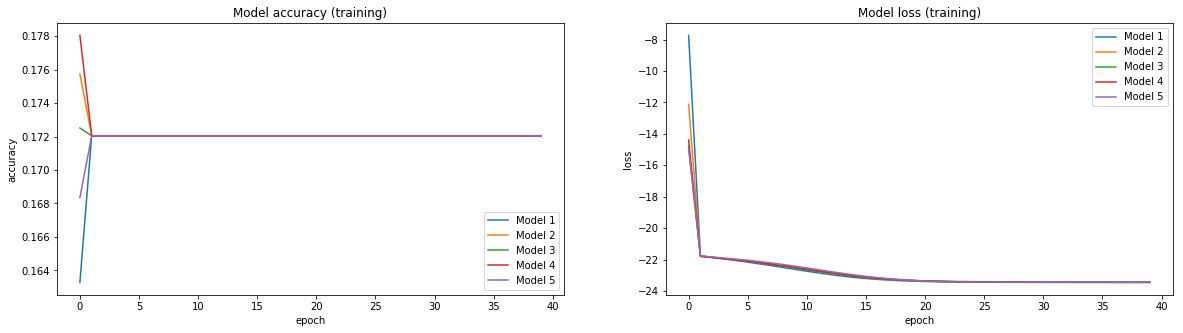

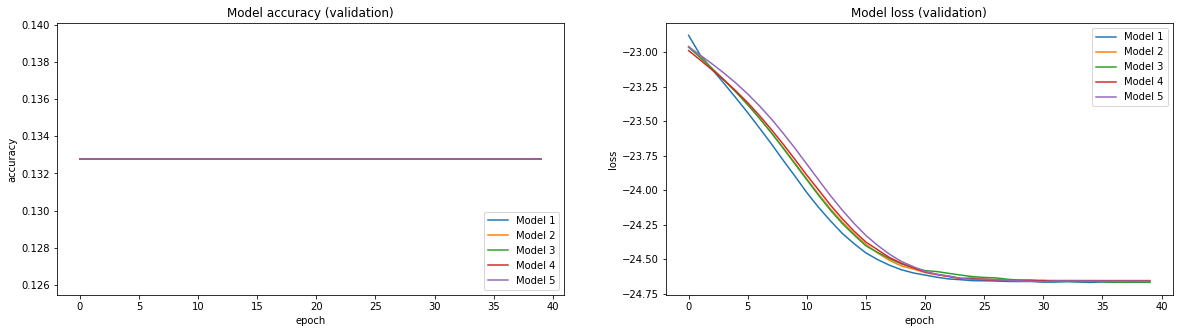

In [261]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')